In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Input
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#https://www.kaggle.com/datasets/hrishi1563/sql-injection-dataset-with-sqlfeaturesvalue/data
df = pd.read_csv("./SQL_Injection.csv")
df.describe()

,Label,Sentence Length,AND Count,OR Count,UNION Count,Single Quote Count,Double Quote Count,Constant Value Count,Parentheses Count,Special Characters Total
count,30919.000000,30919.000000,30919.000000,30919.000000,30919.000000,30919.000000,30919.000000,30919.000000,30919.000000,30919.000000
mean,0.368123,68.594845,0.239626,0.127430,0.097222,0.833468,0.256703,2.213914,3.127494,1.447233
std,0.482303,81.068616,0.520416,0.348911,0.330919,1.663833,0.863389,3.529712,6.687481,3.909025
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,80.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000,3.000000,1.000000
max,1.000000,5370.000000,6.000000,4.000000,3.000000,13.000000,20.000000,32.000000,44.000000,320.000000


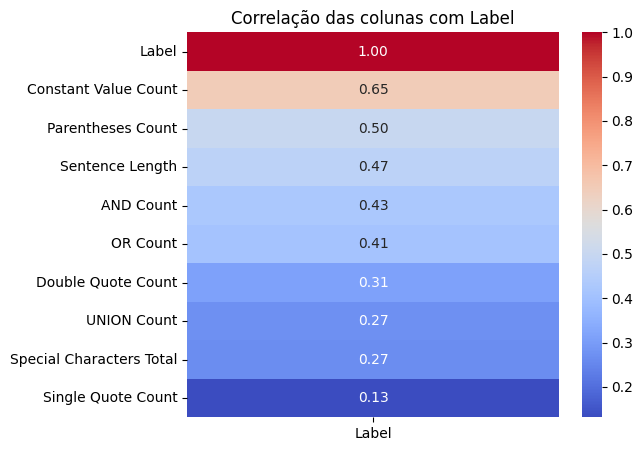

In [3]:
df_corr = df.drop(columns=["Query"]).corr()

label_corr = df_corr[["Label"]].sort_values(by="Label", ascending=False)

plt.figure(figsize=(6, len(label_corr)*0.5))
sns.heatmap(label_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlação das colunas com Label")
plt.show()

In [4]:
y = df["Label"].values
x = df.drop(columns=["Label", "Query"]).values

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=42)

In [6]:
mlp = Sequential()
mlp.add(Input(shape=(9,)))
mlp.add(Dense(8, activation='relu'))
mlp.add(Dense(1, activation='sigmoid'))

In [7]:
mlp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 8)                   │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89 (356.00 B)

 Trainable params: 89 (356.00 B)

 Non-trainable params: 0 (0.00 B)

In [8]:
mlp.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics = ['accuracy'])

In [9]:
mlp.fit(x_train, y_train, epochs=10, verbose=1)

Epoch 1/10
677/677 ━━━━━━━━━━━━━━━━━━━━ 1s 841us/step - accuracy: 0.6645 - loss: 1.7693
Epoch 2/10
677/677 ━━━━━━━━━━━━━━━━━━━━ 1s 860us/step - accuracy: 0.9476 - loss: 0.2119
Epoch 3/10
677/677 ━━━━━━━━━━━━━━━━━━━━ 1s 793us/step - accuracy: 0.9443 - loss: 0.1813
Epoch 4/10
677/677 ━━━━━━━━━━━━━━━━━━━━ 1s 824us/step - accuracy: 0.9406 - loss: 0.1737
Epoch 5/10
677/677 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step - accuracy: 0.9385 - loss: 0.1769
Epoch 6/10
677/677 ━━━━━━━━━━━━━━━━━━━━ 1s 854us/step - accuracy: 0.9385 - loss: 0.1788
Epoch 7/10
677/677 ━━━━━━━━━━━━━━━━━━━━ 1s 844us/step - accuracy: 0.9416 - loss: 0.1712
Epoch 8/10
677/677 ━━━━━━━━━━━━━━━━━━━━ 1s 876us/step - accuracy: 0.9431 - loss: 0.1703
Epoch 9/10
677/677 ━━━━━━━━━━━━━━━━━━━━ 1s 818us/step - accuracy: 0.9359 - loss: 0.1777
Epoch 10/10
677/677 ━━━━━━━━━━━━━━━━━━━━ 1s 828us/step - accuracy: 0.9450 - loss: 0.1667


In [10]:
_, acuracia = mlp.evaluate(x_test, y_test)
print("Acurácia: %.2f" %(acuracia*100))

290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - accuracy: 0.9466 - loss: 0.1601
Acurácia: 94.81


In [11]:
previsoes = mlp.predict(x_test, verbose=0)
rounded_previsoes = [round(x[0]) for x in previsoes]

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

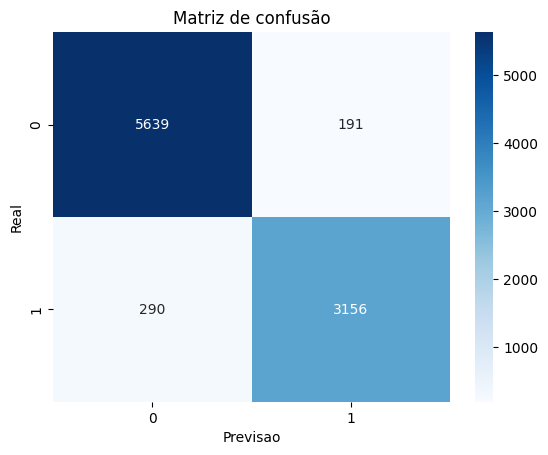

In [13]:
conf_mat = confusion_matrix(y_test, rounded_previsoes)

sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues")
plt.xlabel('Previsao')
plt.ylabel('Real')
plt.title('Matriz de confusão')
plt.show()